In [209]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from torch.utils.data import DataLoader, TensorDataset

# 构建一个简单的 LSTM 模型
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers=2, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])  # 取序列最后一个时间点的输出
        return out

In [204]:

# 准备数据
# 假设你有一个名为 time_series 的 pandas DataFrame，其中一列为时间序列数据
# 这里假设你使用时间序列的前一部分作为输入，预测后一部分

# 生成示例数据
np.random.seed(0)
data = pd.read_csv("./LBMA-GOLD.csv")
df = pd.DataFrame(data, columns=['USD (PM)']).dropna()
df.describe()


,USD (PM)
count,1255.000000
mean,1464.549402
std,249.291812
min,1125.700000
25%,1266.175000
50%,1329.050000
75%,1723.750000
max,2067.150000


In [205]:
# 数据预处理
scaler = MinMaxScaler(feature_range=(-1, 1))
df['scaled_value'] = scaler.fit_transform(df['USD (PM)'].values.reshape(-1, 1))

# 划分训练集和测试集
train_size = int(len(df) * 0.8)
train_data, test_data = df.iloc[:train_size], df.iloc[train_size:]

# 定义函数，将时间序列数据转换为适用于 LSTM 输入的格式
def create_sequences(data, seq_length):
    sequences = []
    for i in range(len(data) - seq_length):
        seq = data[i:i+seq_length]
        label = data[i+seq_length]
        sequences.append((seq, label))
    return sequences


# 定义超参数
input_size = 1
hidden_size = 50
output_size = 1
sequence_length = 10
num_epochs = 300
learning_rate = 0.001
device = torch.device('cuda')
# 转换数据为模型输入格式
train_sequences = create_sequences(train_data['scaled_value'].values, sequence_length)
test_sequences = create_sequences(test_data['scaled_value'].values, sequence_length)

train_X, train_y = zip(*train_sequences)
test_X, test_y = zip(*test_sequences)

train_X = torch.tensor(np.array(train_X), dtype=torch.float32).unsqueeze(2)
train_y = torch.tensor(np.array(train_y), dtype=torch.float32)

test_X = torch.tensor(np.array(test_X), dtype=torch.float32).unsqueeze(2)
test_y = torch.tensor(np.array(test_y), dtype=torch.float32)

# 创建数据加载器
train_dataset = TensorDataset(train_X, train_y)
test_dataset = TensorDataset(test_X, test_y)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(train_dataset, batch_size=1, shuffle=False)


In [206]:

# 初始化模型、损失函数和优化器
model = LSTMModel(input_size, hidden_size, output_size).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# 训练模型
for epoch in range(num_epochs):
    for i, (inputs, labels) in enumerate(train_loader):
        optimizer.zero_grad()
        outputs = model(inputs.to(device))
        loss = criterion(outputs.flatten(), labels.to(device))
        loss.backward()
        optimizer.step()
        if (i+1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}')

In [207]:
# 测试模型
model.eval()

with torch.no_grad():
    predictions = []
    for inputs, labels in test_loader:
        outputs = model(inputs.to(device)).to('cpu')
        predictions.append(outputs.item())

# 反归一化
predicted_values = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))

# 计算均方根误差
true_values = train_data['USD (PM)'].values[sequence_length:]
rmse = np.sqrt(mean_squared_error(true_values, predicted_values))
print(f'Root Mean Squared Error: {rmse}')

Root Mean Squared Error: 12.55994049330093


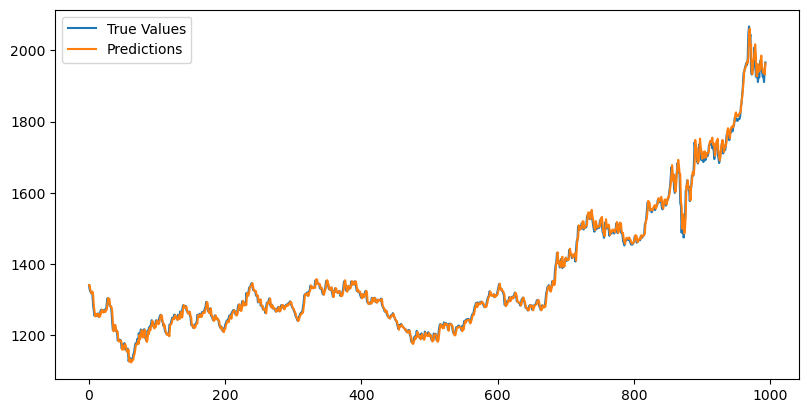

In [208]:

# 可视化预测结果
import matplotlib.pyplot as plt
plt.figure(figsize=(6.4*1.5,4.8))
plt.plot(train_data['USD (PM)'].values[sequence_length:], label='True Values')
plt.plot(predicted_values, label='Predictions')
plt.legend()
plt.show()
